In [3]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x +5

In [5]:
f(2.5)

13.75

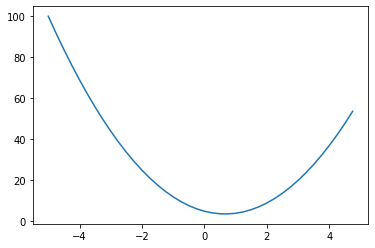

In [6]:
xs = np.arange(-5,5, 0.25)
pro = f(xs)
pro
plt.plot(xs, pro)

In [7]:
x=2/3
h=0.0000001
(f(x+h)- f(x))/h

2.9753977059954195e-07

In [8]:
a=2.0
b=-3.0
c=10.0
d=a*b+c
d

4.0

In [9]:
h=0.0001

a=2.0
b=-3.0
c=10.0

d1 =  a*b + c
c += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [10]:
class Value:
    
    def __init__(self, data, _children=[], _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self.grad = 0.0
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f'Value(Data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,  (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
   
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
 
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __radd__(self, other): # other + self
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, {self, }, "tanh")
        
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x), {self}, 'exp')
        
        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
    
        return out

In [11]:
a = Value(2.0)
b = Value(-4.0)
a-b

Value(Data=6.0)

In [12]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
        
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }"%(n.label, n.data, n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [13]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"

n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"
o.backward()

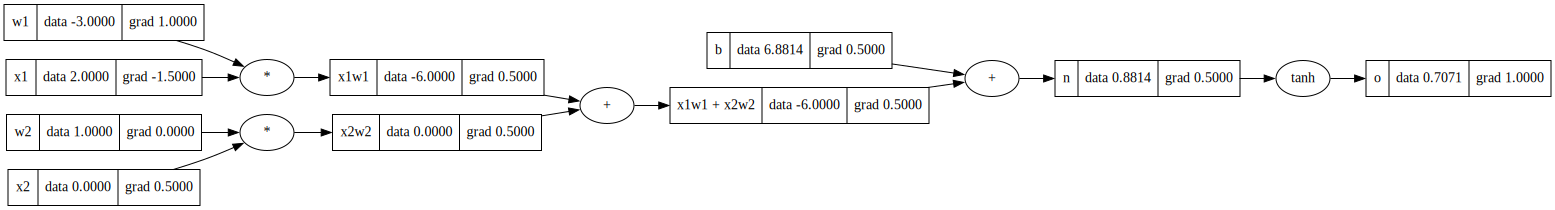

In [14]:
draw_dot(o)

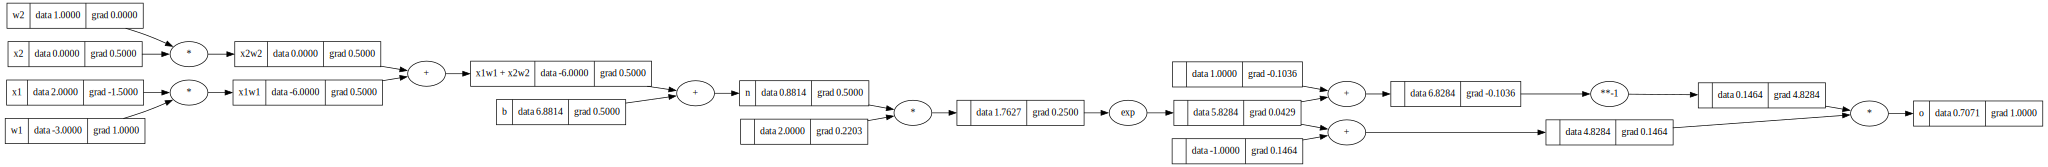

In [15]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"

n = x1w1x2w2 + b; n.label = "n"

e = (2*n).exp()
o = (e-1)/(e+1)
o.label="o"
o.backward()
draw_dot(o)

In [16]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [17]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
          return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
          return [p for layer in self.layers for p in layer.parameters()]

In [24]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(Data=-0.407413984683326)

In [25]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [0.5, -1.0, -0.5, 1.0] 

In [36]:
for k in range(50):
    ## forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.05  * p.grad
        
    print(k, loss.data)
    

0 0.001016678127301402
1 0.0010142814809366847
2 0.0010118957570096302
3 0.0010095208819778248
4 0.0010071567829528438
5 0.0010048033876930813
6 0.001002460624596611
7 0.0010001284226941359
8 0.0009978067116420746
9 0.0009954954217156978
10 0.0009931944838023627
11 0.0009909038293948829
12 0.0009886233905848812
13 0.0009863531000563325
14 0.0009840928910791493
15 0.0009818426975028278
16 0.000979602453750219
17 0.0009773720948113508
18 0.00097515155623733
19 0.0009729407741343477
20 0.0009707396851577364
21 0.0009685482265060794
22 0.000966366335915491
23 0.0009641939516538485
24 0.0009620310125151793
25 0.0009598774578140818
26 0.0009577332273802309
27 0.0009555982615529647
28 0.0009534725011758914
29 0.0009513558875916356
30 0.0009492483626365901
31 0.0009471498686357532
32 0.0009450603483976428
33 0.0009429797452092408
34 0.0009409080028310796
35 0.0009388450654922454
36 0.0009367908778856157
37 0.0009347453851630083
38 0.0009327085329305033
39 0.0009306802672437149
40 0.00092866053

In [37]:
ypred

[Value(Data=0.500815972098143),
 Value(Data=-0.9867960392160201),
 Value(Data=-0.5000509668343797),
 Value(Data=0.9728735308871468)]